## MCS characteristics in Sichuan basin for water year 2019 - 2020 

In [1]:
import xarray as xr 
import numpy as np 
import pickle
from pathlib import Path 
import matplotlib.pyplot as plt 
from skimage.measure import regionprops, regionprops_table
from scipy import ndimage
import seaborn as sns 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy.crs as ccrs
import seaborn as sns 
%matplotlib inline
#import cmasher as cmr
import matplotlib as mpl 
import cartopy.feature as cfeature 

# elevation data 
dem = '~/data/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
longitude = elevations.lon.values
latitude= elevations.lat.values
lo, la = np.meshgrid(longitude, latitude)

minlat, maxlat = 20, 45 
minlon, maxlon = 65, 120


In [2]:
path = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
features = list(path.glob('Precip_tracking_water-year20????_WRF'))
features.sort()

precip_cells = list(path.glob('Precip_tracking_water-year_20????_WRF.nc'))
precip_cells.sort()

In [5]:
# GPM tracks in Sichuan basin 
path = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
features = list(path.glob('Precip_tracking_water-year20????_GPM'))
features.sort()

precip_cells = list(path.glob('Precip_tracking_water-year_20????_GPM.nc'))
precip_cells.sort()

scratch = Path('/glade/scratch/kukulies/tbb/')
clouds = list(scratch.glob('mergir*nc4'))
clouds.sort()


# elevation data 
dem = '~/data/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)

minlon, maxlon = 102, 112
minlat, maxlat = 27, 35 

#### Seasonal cycle 

In [62]:
objects = np.array(())
with open(fname, 'rb') as f:
    monthly = pickle.load(f)
    if 'nudging' in str(fname): 
        for key in monthly.keys():
            times = pd.to_datetime(monthly[key]['TimeAct'])
            for tt in times:
                if tt.day == 31:
                    #drop key from dict 
                    #del monthly[key]
                    #print(fname, 'dropped', key, tt)

                    monthly.pop(key, None)
    object_nr = len(list(monthly.keys()))
    objects = np.append(objects, object_nr)


RuntimeError: dictionary changed size during iteration

In [3]:
def seasonal_cycle(features):
    objects = np.array(())
    for fname in features:
        with open(fname, 'rb') as f:
            monthly = pickle.load(f)
            object_nr = len(list(monthly.keys()))
            objects = np.append(objects, object_nr)
    return objects

#### Diurnal cycle

In [5]:
hours = np.array(())
for fname in features:
    with open(fname, 'rb') as f:
        monthly = pickle.load(f)
        for key in list(monthly.keys())[1:]:
            cell_hours= pd.DatetimeIndex(monthly[key]['TimeAct']).hour
            hours = np.append(hours, cell_hours) 
hour_counts,bins = np.histogram(hours,bins = np.arange(25), normed = True) 

#### Lifetime distribution

In [203]:
lifetimes = np.array(())
for fname in features:
    with open(fname, 'rb') as f:
        monthly = pickle.load(f)
        for key in list(monthly.keys())[1:]:
            lt = monthly[key]['TimeAct'].shape[0]
            lifetimes = np.append(lifetimes, lt )
lifetime_counts,bins_lt = np.histogram(lifetimes, bins = np.arange(4,34,1), normed = True)

#### Total rainfall volume per track

In [204]:
rainfall= np.array(())

for fname in features:
    with open(fname, 'rb') as f:
        monthly = pickle.load(f)
        for key in list(monthly.keys())[1:]:
            rainvol = np.nansum(monthly[key]['rgrPR_Vol']) 
            rainfall = np.append(rainfall, rainvol )
            
rainfall_counts,bins_rv = np.histogram(rainfall / 10**6 , bins = np.arange(0,500,20), normed = True)

## Summary plot of all convective cells (> 3mm/hr > 4 hours) in entire TP domain

In [10]:
sns.set()

plt.figure(figsize=(18, 10 )) 
fs= 20

ax = plt.subplot(2,2,1)
months = ['J','F','M','A','M','J','J', 'A', 'S', 'O','N','D',]
seasonal = np.append(objects[3:] , objects[0:3])
ax.plot(np.arange(12), seasonal)
ax.set_xticks(np.arange(12))
ax.set_xticklabels(months)
ax.set_title('a)', fontsize = fs, loc = 'left') 


ax = plt.subplot(2,2,2)
ax.plot(bins[:-1], hour_counts)
ax.set_title('b)', fontsize = fs, loc = 'left')
ax.set_xlabel('hour [UTC]') 


ax = plt.subplot(2,2,3)
ax.bar(bins_lt[:-1], lifetime_counts, width = 0.8)
ax.set_title('c)', fontsize = fs, loc = 'left')
ax.set_xlabel('lifetime [hours]') 



ax = plt.subplot(2,2,4)
ax.bar(bins_rv[:-1], rainfall_counts, width = 15)
ax.set_title('d)', fontsize = fs, loc = 'left')
ax.set_xlabel('Total rainfall volume [ ]') 

plt.show()

## Filter out MCSs  - use modified dictionary with characteristics from  cloud collocations

Additional criteria (from Feng et al., 2021): 

- $<$ 240 K with areas >  10^4 km2 > 4hours 
- $>$ 3mm/h with major axis > 100 km > 4 hours 
- $>$ 225 K present 

## MCS stats


In [10]:
minlat, maxlat = 28, 33
minlon, maxlon = 102, 105

### get statistics for filtered MCSs ###
# initialize counters 
mcs_seasonal = np.zeros((12,))
mcs_sichuan = np.zeros((12,))
lifetimes_mcs = np.array(())
hours_mcs = np.array(())
hours =  4
mon = 0 
path = Path('/glade/scratch/kukulies/tracks/water-year/precip/')
mcs_files = list(path.glob('*WRF*cloud-colocs'))
mcs_files.sort()
for fname in mcs_files:
    sichuan = dict()
    newdict = dict()
    with open(fname, 'rb') as f:
        monthly = pickle.load(f)
        for key in monthly.keys():
            lst = monthly[key]['major_axis_length']
            lst2 = monthly[key]['cloud_area']
            # check condition on cloud and axis features by replacing entries with 1 and 0 
            pf_axis = (np.array(monthly[key]['major_axis_length']) > 100 ) * 1
            cloud_shield = (np.array(monthly[key]['cloud_area']) > 1e10 ) * 1 
            cold_core = (np.array(monthly[key]['cloud_min']) < 225 ) * 1 
            regions = ndimage.find_objects(ndimage.label(pf_axis)[0])
            pf_regions = [np.sum(pf_axis[r]) for r in regions]
            regions = ndimage.find_objects(ndimage.label(cloud_shield)[1])
            cl_regions = [np.sum(cloud_shield[r]) for r in regions]
            regions = ndimage.find_objects(ndimage.label(cloud_shield)[1])
            cc = [np.sum(cold_core[r]) for r in regions]
            
            if np.array(cl_regions).sum() > 0 and np.array(pf_axis).sum() > 0:
                # check if more than 4 pf100km and 240K cloud shields exist:
                if np.array(cl_regions).max() > hours and np.array(pf_regions).max() > hours and np.array(cc).max() > hours:
                #np.array(monthly[key]['cloud_min']).min() < 225:
                    mcs_seasonal[mon] += 1 
                    newdict[key] = monthly[key]
                    # diurnal
                    cell_hours= pd.DatetimeIndex(monthly[key]['TimeAct']).hour
                    hours_mcs= np.append(hours_mcs, cell_hours) 
                    # lifetime 
                    lt = monthly[key]['TimeAct'].shape[0]
                    lifetimes_mcs = np.append(lifetimes_mcs, lt )
                    # filter out sichuan MCSs                                                              
                    lats = monthly[key]['rgrMassCentLatLon'][:,1]                                                                                                
                    lons = monthly[key]['rgrMassCentLatLon'][:,0]                                                                                                
                    for idx, lat in enumerate(lats):
                        lon = lons[idx]
                        if lat > minlat and lat < maxlat and lon > minlon and lon < maxlon : 
                            sichuan[key] = monthly[key]
                            sichuan_flag = 1
                            break
                        else:
                            sichuan_flag  = 0 
                            
                    if sichuan_flag ==1:
                        mcs_sichuan[mon] +=1 
    # save MCS dict 
    with open(str(fname) + '-mcs.pickle', 'wb') as handle:
        pickle.dump(newdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()
    with open(str(fname) + '-sichuan.pickle', 'wb') as handle:
        pickle.dump(sichuan, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()
    f.close()
    mon += 1 

hour_mcs_counts,bins = np.histogram(hours_mcs,bins = np.arange(25), normed = True) 
lifetime_mcs_counts,bins_lt = np.histogram(lifetimes_mcs, bins = np.arange(4,34,1), normed = True)

KeyboardInterrupt: 

In [148]:
print('Observed:')
print(objects, mcs_seasonal, mcs_sichuan)

Observed:
[1183.  387.  195.  481.  383.  836. 1208. 1549. 2691. 3685. 3511. 2637.] [129.  35.  13.  33.  26.  84. 145. 230. 473. 659. 647. 411.] [ 1.  0.  1.  5.  2.  5.  4. 10. 28. 25. 23.  7.]


In [125]:
print('Simulated')
print(objects, mcs_seasonal, mcs_sichuan)

Simulated:
[3621.  876.  496.  588.  574. 1275. 1971. 3501. 7932. 9878.] [129.  22.  17.  18.  24.  85. 182. 243. 525. 588.   0.   0.] [ 0.  0.  1.  0.  0.  7.  6.  9. 26. 25.  0.  0.]


### Plot: seasonal cycle of tracked MCSs in observations vs. simulations 

In [4]:
observed_sichuan= list(path.glob('*CPC*_mcs.pickle'))
observed_sichuan.sort()
simulated_sichuan= list(path.glob('*20????_WRF*-mcs.pickle'))
simulated_sichuan.sort()

simulated_sichuan_n= list(path.glob('*nudging*-mcs.pickle'))
simulated_sichuan_n.sort()

wrf_sichuan = seasonal_cycle(simulated_sichuan)

wrf_sichuan_n = seasonal_cycle(simulated_sichuan_n)

In [5]:
import matplotlib.patches as mpatches

In [6]:
# read in dictionary with all classified MCSs
path = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
obs= list(path.glob('*CPC*mcs.pickle'))
obs.sort()
wrf= list(path.glob('*20????_WRF*mcs.pickle'))
wrf.sort()
wrf_n= list(path.glob('*nudging*mcs.pickle'))
wrf_n.sort()
wrf_seasonal = seasonal_cycle(wrf)
wrf_seasonal_n = seasonal_cycle(wrf_n)
obs_seasonal = seasonal_cycle(obs) 

# for Sichuan basin 
observed_sichuan= list(path.glob('*CPC*_sichuan.pickle'))
observed_sichuan.sort()
simulated_sichuan= list(path.glob('*20????_WRF*_sichuan.pickle'))
simulated_sichuan.sort()
simulated_sichuan_n= list(path.glob('*nudging*_sichuan.pickle'))
simulated_sichuan_n.sort()

wrf_sichuan = seasonal_cycle(simulated_sichuan)
obs_sichuan= seasonal_cycle(observed_sichuan)
wrf_sichuan_n= seasonal_cycle(simulated_sichuan_n)

### show MCS density instead of tracks ### 
wrf_density = xr.open_dataarray('/glade/scratch/kukulies/tracks/water-year/tbb/mcs_density_wrf.nc')
gpm_density = xr.open_dataarray('/glade/scratch/kukulies/tracks/water-year/tbb/mcs_density_gpm.nc')
wrf_density_n = xr.open_dataarray('/glade/scratch/kukulies/tracks/water-year/tbb/mcs_density_wrf-nudging.nc')

### get coords ### 
ds = xr.open_dataset('/glade/scratch/kukulies/WY2020/pr/pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_2020-07_regridded.nc')
wrf_lons = ds.lon 
wrf_lats = ds.lat

In [7]:
precip1= xr.open_dataset('/glade/scratch/kukulies/WY2020/nudging/olr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r2i1p1_BNU-WRF421P_v1_hour_2020-08.nc')

In [8]:
precip2= xr.open_dataset('/glade/scratch/kukulies/WY2020/olr/olr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_2020-08.nc')

In [9]:
precip=precip1.olr.mean('Time') 
precip_nud=precip2.olr.mean('Time')

In [78]:
sns.set()
fig =plt.figure(figsize=(18, 6))

ROWS = 1 
COLS = 2 
lw = 2.8
fs = 18
lsize= 18
col1, col2, col3 = 'darkslategray', 'mediumaquamarine', 'powderblue'

ticks = np.arange(12)
ticks2 = np.arange(12)
width = 0.25
months = ['O', 'N', 'D', 'J', 'F', 'M', 'A',  'M', 'J', 'J', 'A', 'S']

ax = plt.subplot(ROWS,COLS,1)
ax.bar(ticks2+ width/2, obs_seasonal, color = col1 , label = 'Obs',width = width)
ax.bar(ticks- width/2, wrf_seasonal, color = col2 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2+ width + width/2  , wrf_seasonal_n, color = col3 , label = 'WRF$_{nudging}$', width = width)
ax.set_ylabel('Number of tracked MCSs', fontsize = fs )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = 15)
ax.set_yticks(np.arange(0,500,100))
ax.set_yticklabels(np.arange(0,500,100), fontsize = 15)
ax.legend(fontsize = lsize , loc = 'upper left')
ax.set_title('a) All MCSs ', fontsize = fs, loc ='left')


ax = plt.subplot(ROWS,COLS,2)
ax.bar(ticks2 + width/2, obs_sichuan, color = col1 , label = 'Obs', width = width)
ax.bar(ticks- width/2, wrf_sichuan, color = col2 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2+ width + width/2  , wrf_sichuan_n, color = col3 , label = 'WRF$_{nudging}$', width = width)
ax.set_ylabel('Number of tracked MCSs', fontsize = fs )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = 15)
ax.set_yticks(np.arange(0,35,5))
ax.set_yticklabels(np.arange(0,35,5), fontsize = 15)
ax.legend(fontsize = lsize , loc = 'upper left')
ax.set_title('b) MCSs in Sichuan basin', fontsize = fs, loc ='left')

plt.show()

In [ ]:
### plot #### 
sns.set()
fig =plt.figure(figsize=(12, 22))

In [ ]:
lw = 2.8
fs = 20
lsize= 20
col1, col2 = 'darkslategray', 'mediumaquamarine'
col3 = 'powderblue'
ticks = np.arange(12)
ticks2 = np.arange(12)
width = 0.2
months = ['O', 'N', 'D', 'J', 'F', 'M', 'A',  'M', 'J', 'J', 'A', 'S']

ROWS = 4
COLS = 2 
axes = dict()
axes['1'] = plt.subplot2grid(shape=(ROWS, COLS), loc=(0, 0), colspan=1)
axes['2'] = plt.subplot2grid(shape=(ROWS, COLS), loc=(0, 1), colspan=1)
axes['3']  = plt.subplot2grid(shape=(ROWS, COLS), loc=(1, 0), colspan=2, projection=ccrs.PlateCarree())
axes['4']  = plt.subplot2grid(shape=(ROWS, COLS), loc=(2, 0), colspan=2, projection=ccrs.PlateCarree())
axes['5']  = plt.subplot2grid(shape=(ROWS, COLS), loc=(3, 0), colspan=2, projection=ccrs.PlateCarree())

ax = plt.subplot(ROWS,2,1)
ax = axes['1']
ax.bar(ticks- width/2, wrf_seasonal, color = col1 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2+ width/2, obs_seasonal, color = col2 , label = 'Obs',width = width)
ax.bar(np.arange(8,11)+ width + width/2  , wrf_seasonal_n, color = col3 , label = 'WRF$_{nudging}$', width = width)
ax.set_ylabel('Number of tracked MCSs', fontsize = fs )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = 15)
ax.set_yticks(np.arange(0,500,100))
ax.set_yticklabels(np.arange(0,500,100), fontsize = 15)
ax.legend(fontsize = lsize , loc = 'upper left')
ax.set_title('a) All MCSs ', fontsize = fs, loc ='left')


ax = plt.subplot(ROWS,2,2)
ax = axes['2']
ax.bar(ticks- width/2, wrf_sichuan, color = col1 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2 + width/2, obs_sichuan, color = col2 , label = 'Obs', width = width)
ax.bar(np.arange(8,11)+ width + width/2  , wrf_sichuan_n, color = col3 , label = 'WRF$_{nudging}$', width = width)
ax.set_ylabel('Number of tracked MCSs', fontsize = fs )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = 15)
ax.set_yticks(np.arange(0,35,5))
ax.set_yticklabels(np.arange(0,35,5), fontsize = 15)
ax.legend(fontsize = lsize , loc = 'upper left')
ax.set_title('b) MCSs in Sichuan basin', fontsize = fs, loc ='left')


############################ PLOT TRACK DENSITY ###################################
color = 'midnightblue'
import matplotlib 
matplotlib.rc_file_defaults()
levels = np.arange(0,340,40)
ax = plt.subplot(ROWS, 2, 3 , projection=ccrs.PlateCarree())
ax = axes['3']
fs = 20 
lw = 1.0
extent = [65,120,20,41]
cmap= sns.cubehelix_palette(start=.5, rot=-.6, as_cmap=True)
#cmap = sns.color_palette("ch:start=.2,rot=-.3_r", as_cmap=True)
r= np.array([1, 5, 8, 10,12,15,18 ,20, 30])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.contourf(wrf_lons, wrf_lats, gpm_density, levels = levels, cmap = cmap, extend = 'max')
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.axis('on')
ax.set_title('c) Obs (GPM IMERG & NCEP/CPC)', fontsize = fs, loc ='left')
ax.add_patch(mpatches.Rectangle(xy=[102, 28],width=6, height=6,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,
                                    transform=ccrs.PlateCarree() ))

ax = plt.subplot(ROWS, 2, 4,   frameon=True, projection=ccrs.PlateCarree())
ax = axes['4']
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
m = ax.contourf(wrf_lons, wrf_lats, wrf_density, cmap = cmap,  levels = levels, extend = 'max')
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('d) WRF$_{D2}$', fontsize = fs, loc = 'left')
plt.rcParams.update({'font.size': fs}) 
ax.add_patch(mpatches.Rectangle(xy=[102, 28], width=6, height=6,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,
                                    transform=ccrs.PlateCarree() ))



ax = plt.subplot(ROWS, 2, 5,   frameon=True, projection=ccrs.PlateCarree())
ax = axes['5']
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
m = ax.contourf(wrf_lons, wrf_lats, wrf_density_n, cmap = cmap,  levels = levels, extend = 'max')
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('d) WRF$_{nudging}$', fontsize = fs, loc = 'left')
plt.rcParams.update({'font.size': fs}) 
ax.add_patch(mpatches.Rectangle(xy=[102, 28], width=6, height=6,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,
                
                                transform=ccrs.PlateCarree() )) 

# colorbar 
cb_ax2 = fig.add_axes([0.9, 0.135,0.02, 0.4])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'MCS frequency', size = fs)

plt.tight_layout()
plt.show()

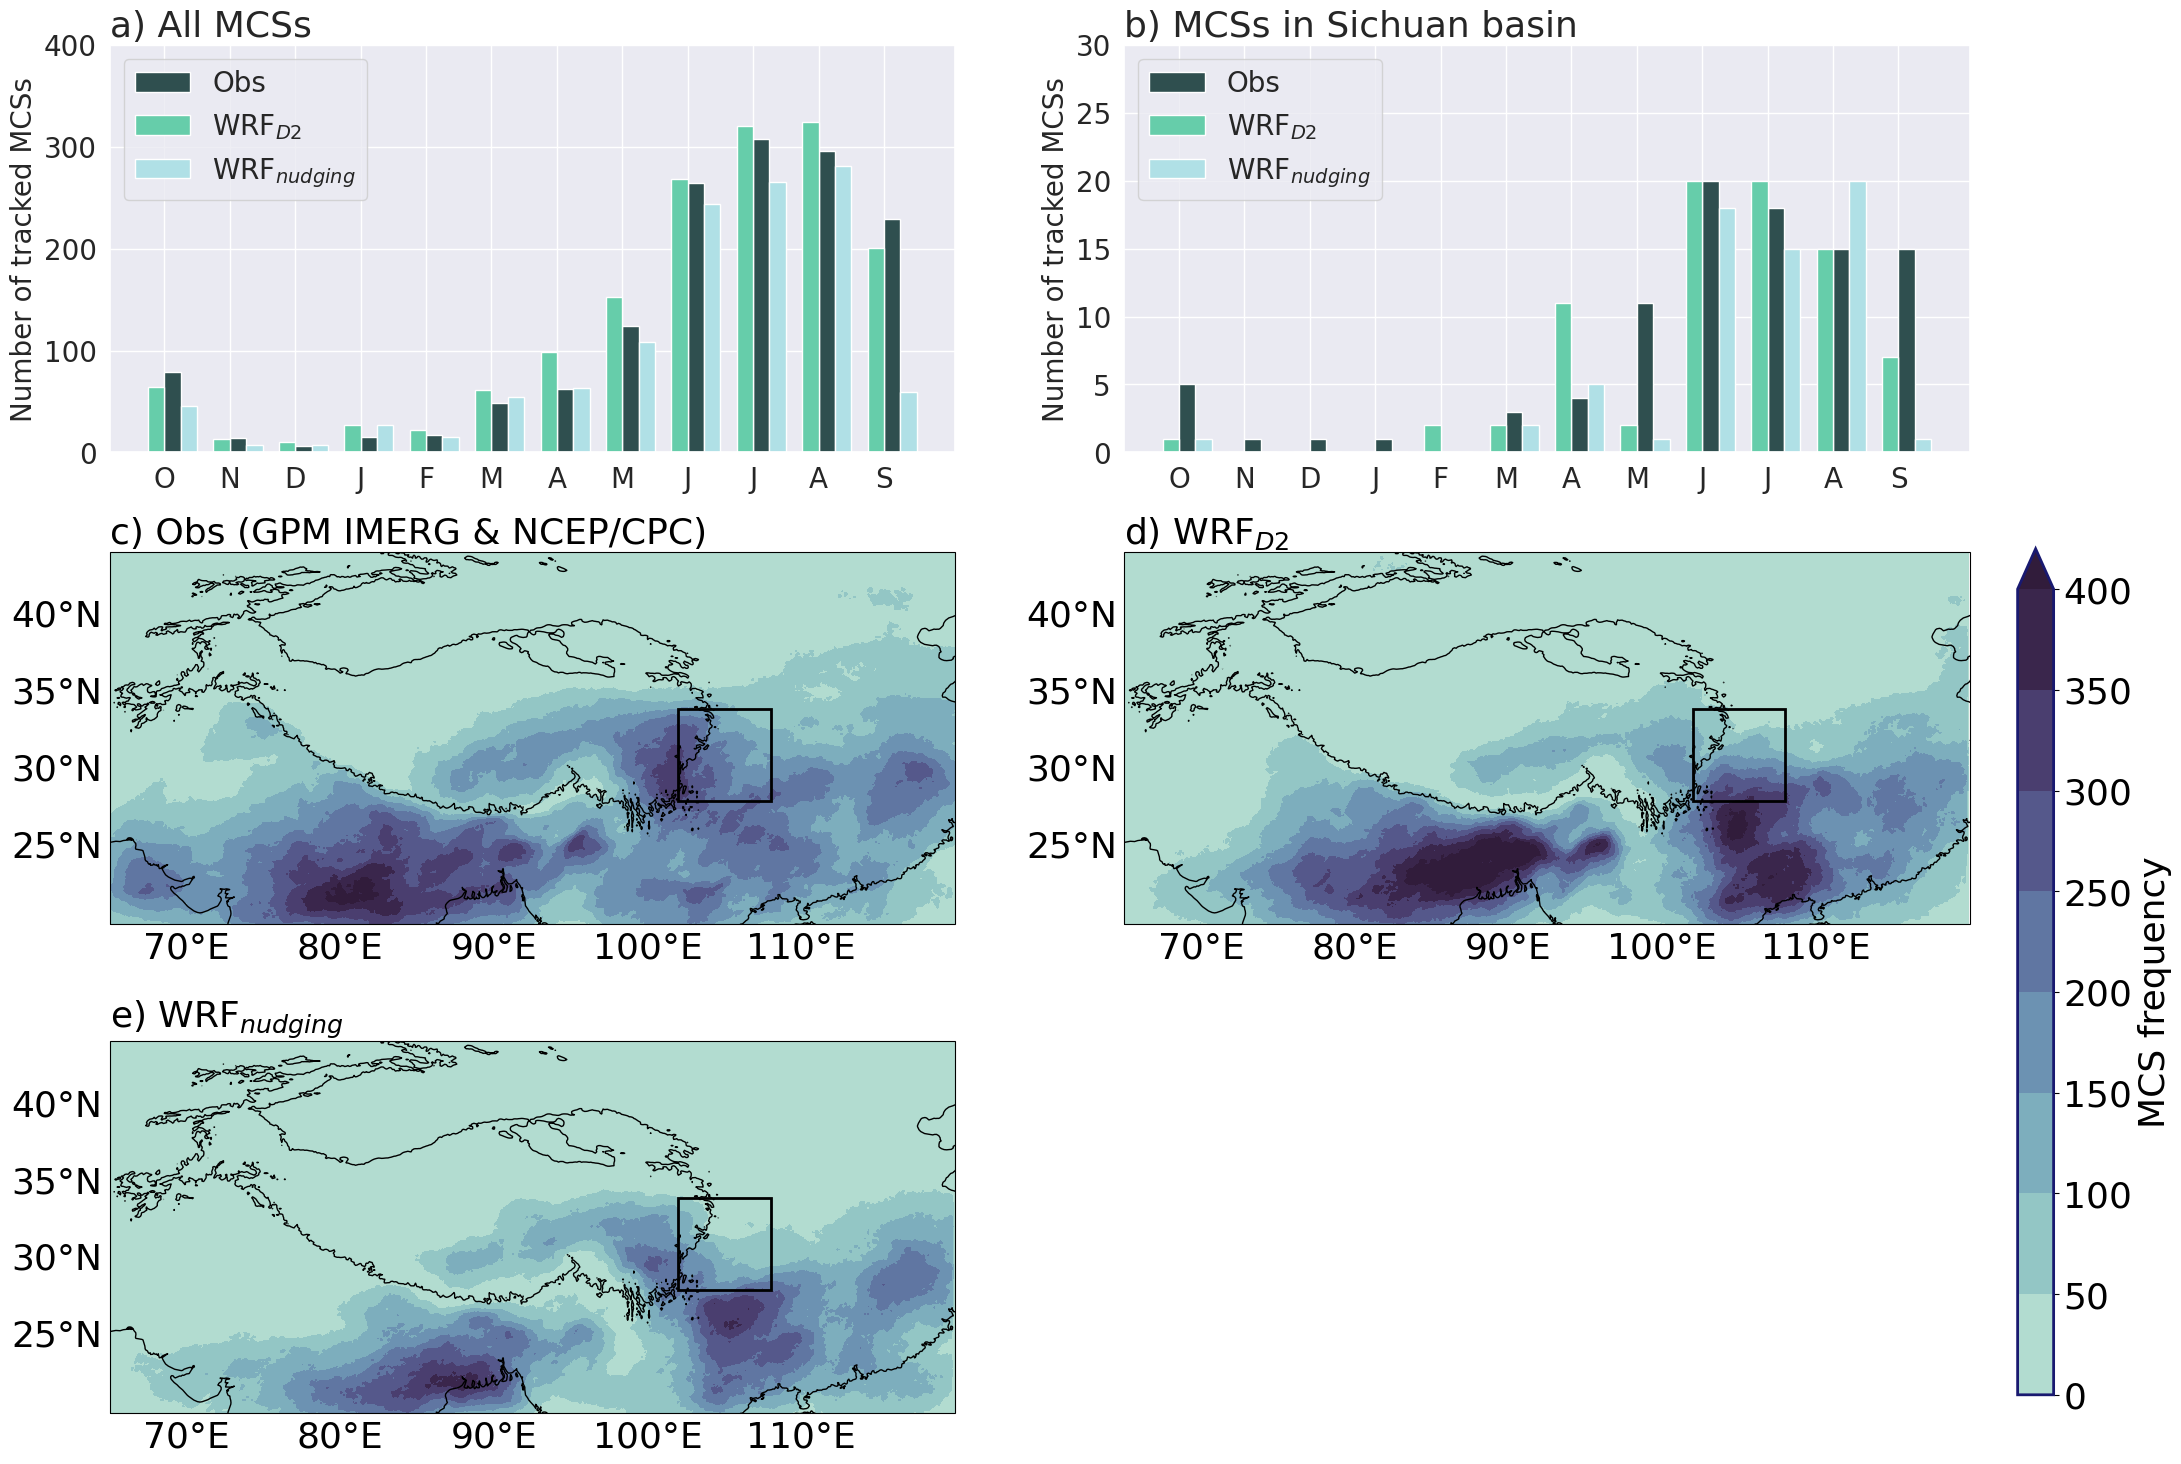

In [11]:
### plot #### 
sns.set()
fig =plt.figure(figsize=(24, 18))


# general settings 
ROWS = 3 
COLS = 2 
lw = 2.8
fs = 26
lsize= 20
col1, col2, col3 = 'darkslategray', 'mediumaquamarine', 'powderblue'

ticks = np.arange(12)
ticks2 = np.arange(12)
width = 0.25
months = ['O', 'N', 'D', 'J', 'F', 'M', 'A',  'M', 'J', 'J', 'A', 'S']

####################################### seasonal cycle of simulated and observed #########################



ax = plt.subplot(ROWS,COLS,1)
ax.bar(ticks2+ width/2, obs_seasonal, color = col1 , label = 'Obs',width = width)
ax.bar(ticks - width/2, wrf_seasonal, color = col2 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2+ width + width/2  , wrf_seasonal_n, color = col3 , label = 'WRF$_{nudging}$', width = width)
ax.set_ylabel('Number of tracked MCSs', fontsize = lsize )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = lsize)
ax.set_yticks(np.arange(0,500,100))
ax.set_yticklabels(np.arange(0,500,100), fontsize = lsize)
ax.legend(fontsize = lsize , loc = 'upper left')
ax.set_title('a) All MCSs ', fontsize = fs, loc ='left')


ax = plt.subplot(ROWS,COLS,2)
ax.bar(ticks2 + width/2, obs_sichuan, color = col1 , label = 'Obs', width = width)
ax.bar(ticks- width/2, wrf_sichuan, color = col2 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2+ width + width/2  , wrf_sichuan_n, color = col3 , label = 'WRF$_{nudging}$', width = width)
ax.set_ylabel('Number of tracked MCSs', fontsize = lsize)
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = lsize)
ax.set_yticks(np.arange(0,35,5))
ax.set_yticklabels(np.arange(0,35,5), fontsize = lsize)
ax.legend(fontsize = lsize , loc = 'upper left')
ax.set_title('b) MCSs in Sichuan basin', fontsize = fs, loc ='left')


############################ PLOT TRACK DENSITY ###################################
color = 'midnightblue'
import matplotlib 
matplotlib.rc_file_defaults()
levels = np.arange(0,450,50)


ax = plt.subplot(ROWS, COLS, 3 , projection=ccrs.PlateCarree())
fs = 26
lw = 1.0
extent = [65,120,20,41]

cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)
#cmap = sns.color_palette("ch:start=.2,rot=-.3_r", as_cmap=True)
r= np.array([1, 5, 8, 10,12,15,18 ,20, 30])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.contourf(wrf_lons, wrf_lats, gpm_density, levels = levels, cmap = cmap, extend = 'max')
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.axis('on')
ax.set_title('c) Obs (GPM IMERG & NCEP/CPC)', fontsize = fs, loc ='left')
ax.add_patch(mpatches.Rectangle(xy=[102, 28],width=6, height=6,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,
                                    transform=ccrs.PlateCarree() ))

ax = plt.subplot(ROWS, COLS, 4,   frameon=True, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
m = ax.contourf(wrf_lons, wrf_lats, wrf_density, cmap = cmap,  levels = levels, extend = 'max')
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('d) WRF$_{D2}$', fontsize = fs, loc = 'left')
plt.rcParams.update({'font.size': fs}) 
ax.add_patch(mpatches.Rectangle(xy=[102, 28], width=6, height=6,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,
     
                                
                    transform=ccrs.PlateCarree() ))



ax = plt.subplot(ROWS, COLS, 5,   frameon=True, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
m = ax.contourf(wrf_lons, wrf_lats, wrf_density_n, cmap = cmap,  levels = levels, extend = 'max')
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('e) WRF$_{nudging}$', fontsize = fs, loc = 'left')
plt.rcParams.update({'font.size': fs}) 
ax.add_patch(mpatches.Rectangle(xy=[102, 28], width=6, height=6,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,    
                    transform=ccrs.PlateCarree() ))

# colorbar 
cb_ax2 = fig.add_axes([0.92, 0.13,0.015, 0.47])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'MCS frequency', size = fs)

plt.savefig('plots/water_year2020_summary_revised.png', bbox_inches = 'tight', transparent = False, facecolor = 'white')
plt.show()

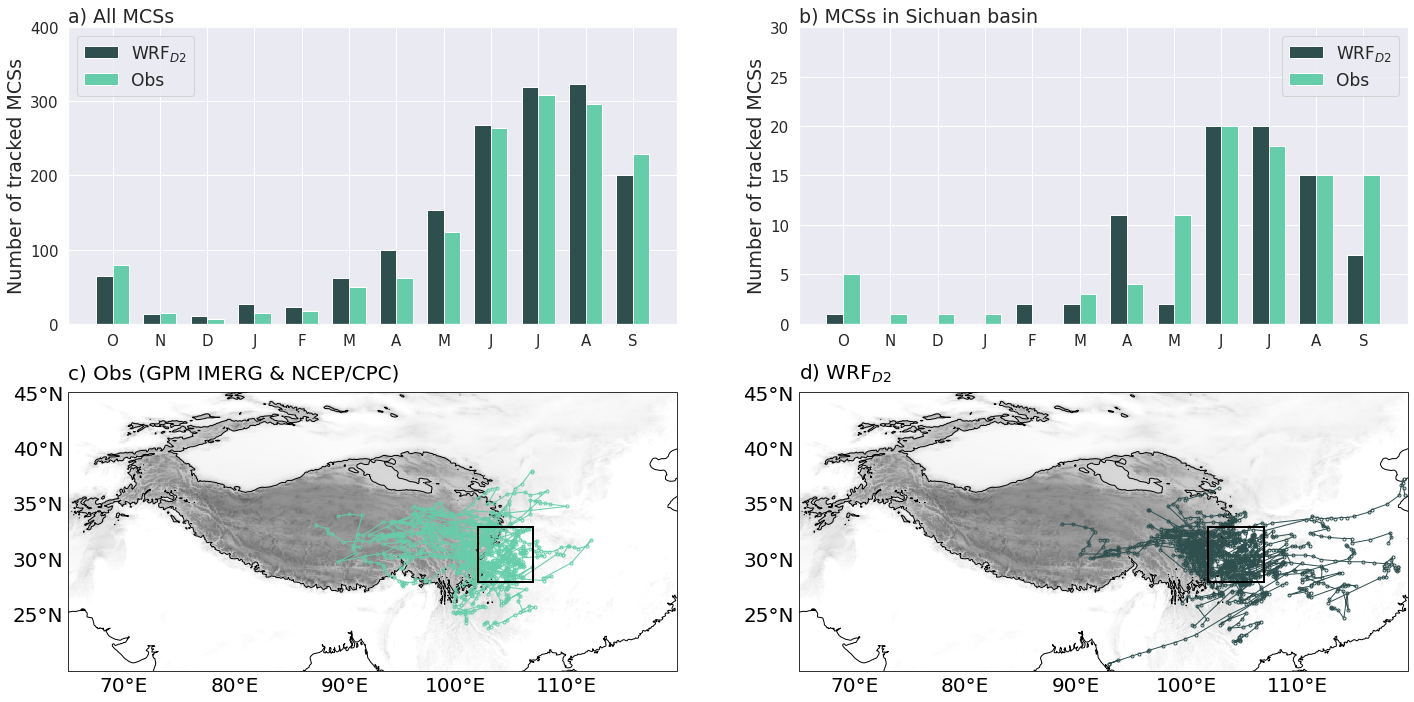

In [12]:
### plot #### 
sns.set()
plt.figure(figsize=(24, 12))
lw = 2.8
fs = 19
lsize= 17
col1, col2 = 'darkslategray', 'mediumaquamarine'
ticks = np.arange(12)
ticks2 = np.arange(12)
width = 0.35
months = ['O', 'N', 'D', 'J', 'F', 'M', 'A',  'M', 'J', 'J', 'A', 'S']

ax = plt.subplot(2,2,1)
ax.bar(ticks- width/2, wrf_seasonal, color = col1 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2+ width/2, obs_seasonal, color = col2 , label = 'Obs',width = width)
#ax.plot(ticks, wrf_seasonal, color = col1 , label = 'WRF4km',lw=lw)
#ax.plot(ticks2, obs_seasonal, color = col2 , label = 'Obs', lw=lw)
ax.set_ylabel('Number of tracked MCSs', fontsize = fs )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = 15)
ax.set_yticks(np.arange(0,500,100))
ax.set_yticklabels(np.arange(0,500,100), fontsize = 15)
ax.legend(fontsize = lsize )
ax.set_title('a) All MCSs ', fontsize = fs, loc ='left')


ax = plt.subplot(2 ,2,2)
ax.bar(ticks- width/2, wrf_sichuan, color = col1 , label = 'WRF$_{D2}$', width = width)
ax.bar(ticks2 + width/2, obs_sichuan, color = col2 , label = 'Obs', width = width)
#ax.plot(ticks, wrf_sichuan, color = col1 , label = 'WRF4km',lw=lw)
#ax.plot(ticks2, obs_sichuan, color = col2 , label = 'Obs', lw=lw)
ax.set_ylabel('Number of tracked MCSs', fontsize = fs )
ax.set_xticks(ticks2)
ax.set_xticklabels(months, fontsize = 15)
ax.set_yticks(np.arange(0,35,5))
ax.set_yticklabels(np.arange(0,35,5), fontsize = 15)
ax.legend(fontsize = lsize)
ax.set_title('b) MCSs in Sichuan basin', fontsize = fs, loc ='left')


############################ PLOT TRACKS ###########################################
color = 'midnightblue'
import matplotlib 
matplotlib.rc_file_defaults()

ax = plt.subplot(2, 2, 3 , projection=ccrs.PlateCarree())
fs = 20 
lw = 1.0
extent = [65,120,20,42]
cmap = sns.color_palette("mako", as_cmap=True)
cmap = sns.color_palette("ch:start=.2,rot=-.3_r", as_cmap=True)
r= np.array([1, 5, 8, 10,12,15,18 ,20, 30])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.pcolormesh(lo, la, elevations.T, cmap = 'Greys', vmin = 500, vmax = 9000)
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.axis('on')
ax.set_title('c) Obs (GPM IMERG & NCEP/CPC)', fontsize = fs, loc ='left')
# plot tracks 
for fname in observed_sichuan[8:11]: 
    with open(fname, 'rb') as f:
        x = pickle.load(f)
    for key in x.keys():
        lats = x[key]['rgrMassCentLatLon'][:,1]
        lons = x[key]['rgrMassCentLatLon'][:,0]
        if np.isnan(lats).sum() == False and np.isnan(lons).sum() == False:
            ax.plot(lons, lats,  lw = lw , color = col2, marker = 'o', fillstyle = 'none', markersize = 3)
    f.close()
    
ax.add_patch(mpatches.Rectangle(xy=[102, 28], width=5, height=5,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5, 
                                    transform=ccrs.PlateCarree() ))


ax = plt.subplot(2, 2, 4,   frameon=True, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.pcolormesh(lo, la, elevations.T, cmap = 'Greys', vmin = 500, vmax = 9000)
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False

ax.set_title('d) WRF$_{D2}$', fontsize = fs, loc = 'left')
plt.rcParams.update({'font.size': fs}) 


# plot tracks 
for fname in simulated_sichuan[8:11]: 
    with open(fname, 'rb') as f:
        x = pickle.load(f)
    for key in x.keys():
        lats = x[key]['rgrMassCentLatLon'][:,1]
        lons = x[key]['rgrMassCentLatLon'][:,0]
        if np.isnan(lats).sum() == False and np.isnan(lons).sum() == False:
            ax.plot(lons, lats,  lw = lw , color = col1, marker = 'o', fillstyle = 'none', markersize = 3)
    f.close()
            
ax.add_patch(mpatches.Rectangle(xy=[102, 28], width=5, height=5,
                                    facecolor= 'none', edgecolor = 'black', linewidth = 2.0,zorder = 5,
                                    transform=ccrs.PlateCarree() ))


plt.savefig('plots/water_year_summary_statistics.png', bbox_inches = 'tight', transparent = False, facecolor = 'white')
plt.show()

#### Note: 

Feng et al. (2021) show around 20 MCS per year in the Sichuan basin. Given that this was an anomalous wet year and given the tracking method is slightly different the results are probably realistic 

## Spatial distribution of MCSs 

- plot MCS tracks in whole domain during summer season: obs vs. simulated 
- plot contribution to total summer precipitation: obs vs. simulated 

In [174]:
from scipy.stats import mannwhitneyu
import datetime 
import pandas as pd 
from calendar import monthrange

In [175]:
monthly_directories = list(Path('/glade/u/home/kukulies/data/obs/gpm/2019-2020/').glob('??????'))
monthly_directories.sort()
summer = monthly_directories[7:]
summer

[PosixPath('/glade/u/home/kukulies/data/obs/gpm/2019-2020/202005'),
 PosixPath('/glade/u/home/kukulies/data/obs/gpm/2019-2020/202006'),
 PosixPath('/glade/u/home/kukulies/data/obs/gpm/2019-2020/202007'),
 PosixPath('/glade/u/home/kukulies/data/obs/gpm/2019-2020/202008'),
 PosixPath('/glade/u/home/kukulies/data/obs/gpm/2019-2020/202009')]

## Plot contribution to total precipitation

In [10]:
# dictionarties with tracked cells during summer 
path = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
simulated_sichuan = list(path.rglob('*0[4-7]*WRF*sichuan.pickle'))
observed_sichuan = list(path.rglob('*0[4-7]*CPC*sichuan.pickle')) 

simulated_mcs= list(path.rglob('*0[5-7]*WRF*mcs.pickle'))
observed_mcs= list(path.rglob('*0[5-7]*CPC*mcs.pickle')) 
observed_mcs.sort()
simulated_mcs.sort()
observed_sichuan.sort()
simulated_sichuan.sort()

In [12]:
# original files to calculate precip climatology
gpm_clim = list(Path('/glade/work/kukulies/obs/gpm/2019-2020/').glob('??????/*0[6-8]*small*.nc'))
wrf_clim = list(Path('/glade/scratch/kukulies/WY2020/pr/').glob('*0[6-8].nc'))
wrf_regrid = list(Path('/glade/scratch/kukulies/WY2020/pr/').glob('*0[6-8]_regridded.nc'))

# same for nudging run 
wrf_clim_n = list(Path('/glade/scratch/kukulies/WY2020/nudging/').glob('pr*0[6-8].nc'))
wrf_regrid_n = list(Path('/glade/scratch/kukulies/WY2020/nudging/').glob('pr*0[6-8]_regridded.nc'))


for idx in range(len(gpm_clim)):
    file = gpm_clim[idx]
    prec = xr.open_dataset(file).precipitationCal.resample(time = '1H').mean()
    prec = prec.where(prec > 0)
    if idx == 0:
        gpm_precip = prec.sum('time') 
    else:
        gpm_precip += prec.sum('time') 
    
for idx in range(len(wrf_clim)):
    file = wrf_clim[idx]
    file2= wrf_regrid[idx]
    file3 = wrf_clim_n[idx]
    file4= wrf_regrid_n[idx]
    
    ds = xr.open_dataset(file).pr * 3600
    ds_r = xr.open_dataset(file2).pr * 3600
    ds = ds.where(  (ds > 0) & (ds < 10000))
    ds_r = ds_r.where(  (ds_r > 0) & (ds_r < 10000))
    
    # nudging 
    ds_n = xr.open_dataset(file3).pr * 3600
    ds_r_n = xr.open_dataset(file4).pr * 3600
    ds_n = ds_n.where(  (ds_n > 0) & (ds_n < 10000))
    ds_r_n = ds_r_n.where(  (ds_r_n > 0) & (ds_r_n < 10000))
    
    if idx == 0:
        wrf_precip = ds.sum(ds.dims[0]) 
        wrf_regridded = ds_r.sum(ds_r.dims[0])
        wrf_precip_n = ds_n.sum(ds_n.dims[0]) 
        wrf_regridded_n = ds_r_n.sum(ds_r_n.dims[0])
    else:
        wrf_precip += ds.sum(ds.dims[0]) 
        wrf_regridded += ds_r.sum(ds_r.dims[0]) 
        wrf_precip_n += ds_n.sum(ds_n.dims[0]) 
        wrf_regridded_n += ds_r.sum(ds_r_n.dims[0])

In [18]:
#gpm = xr.open_dataset(gpm_clim[0]).precipitationCal.resample(time = '1H').mean().sum('time') 
wrf_clim = list(Path('/glade/scratch/kukulies/WY2020/pr/').glob('*0[6-8].nc'))
wrf_clim.sort()
ds = xr.open_dataset(wrf_clim[0])
ds = xr.open_dataset('/glade/scratch/kukulies/WY2020/pr/pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_2019-09.nc')

In [5]:
path = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
contribution_wrf = xr.open_dataarray(path / 'mcs_contribution_wrf.nc')
contribution_gpm = xr.open_dataarray(path / 'mcs_contribution_gpm.nc')
contribution_wrf_n = xr.open_dataarray(path / 'mcs_contribution_wrf-nudging.nc')

In [20]:
ds = xr.open_dataset(wrf_clim[1])
ds.time[100]

<xarray.DataArray 'time' ()>
array('2020-07-05T05:00:00.000000000', dtype='datetime64[ns]')
Attributes:
    FieldType:      104
    MemoryOrder:    0  
    stagger:        
    cell_methods:   Time: mean
    standard_name:  time

In [15]:
# relative contribution through MCSs 
relative_contribution_wrf = contribution_wrf.data  /  wrf_regridded.data * 100 
relative_contribution_wrf_n = contribution_wrf_n.data  /  wrf_regridded.data * 100 
relative_contribution_gpm = contribution_gpm.data / gpm_precip.data.T * 100 

## Maps of Precip, MCS Fraction and Differences in MCS Fraction

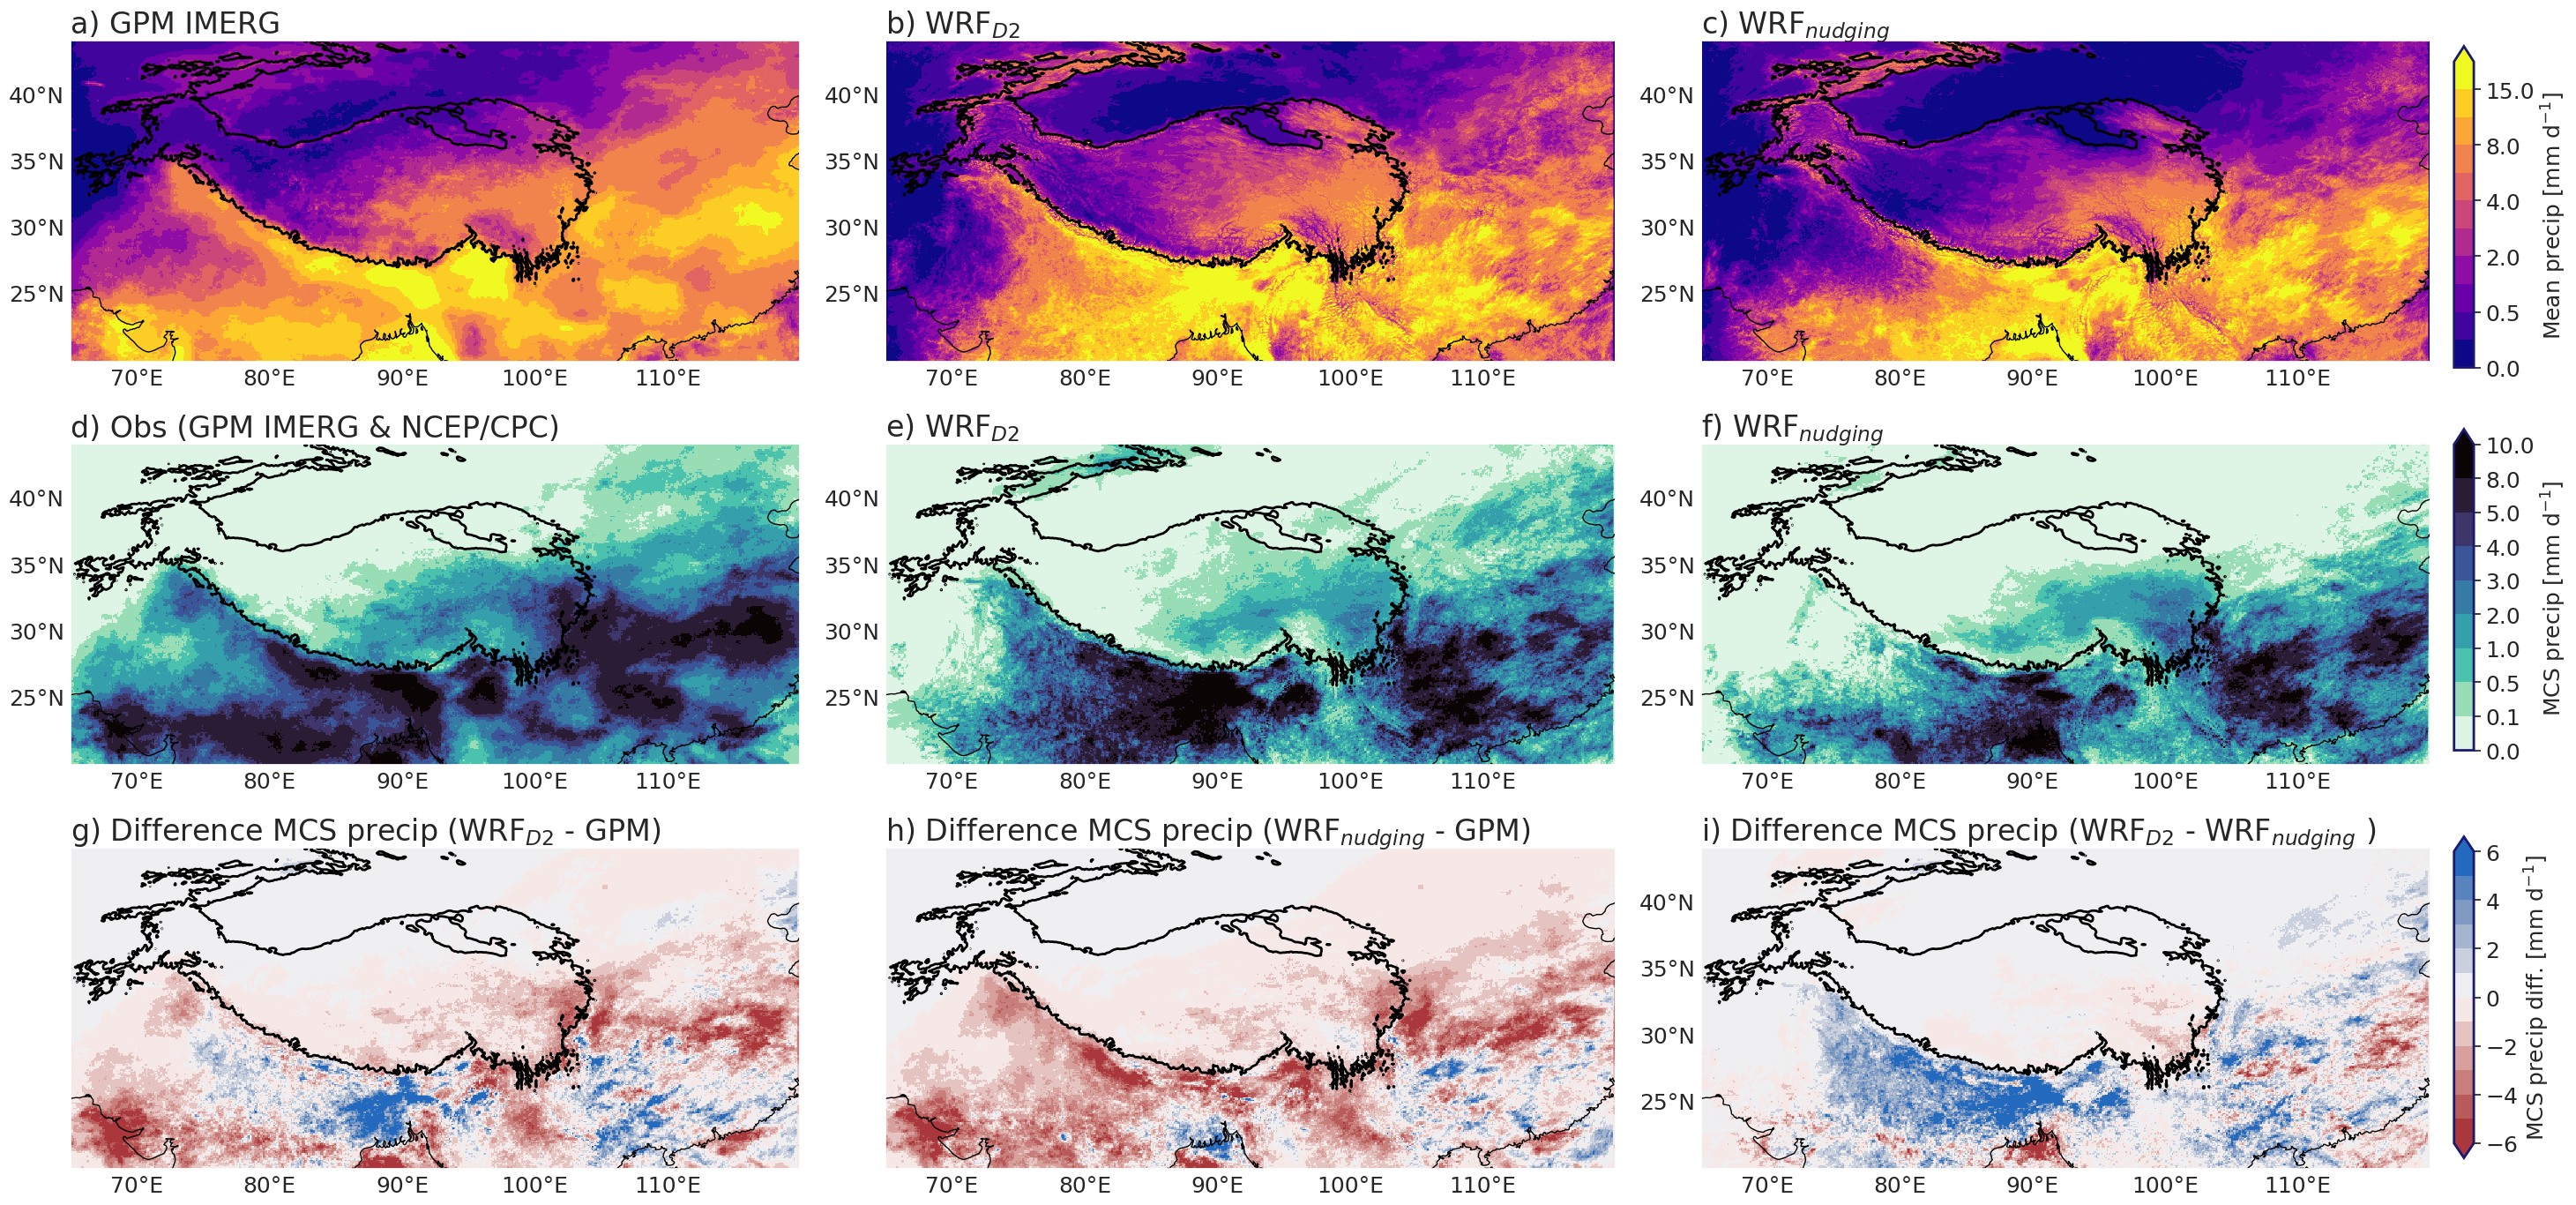

In [40]:
fig = plt.figure(figsize=(28,14))

# general settings
extent = [65,120,20,41]
fs = 18 
lw = 2.0
r= np.array([1, 5, 10, 20, 50, 100, 200,300,400,500, 800, 1000, 1500, 2000])
r= np.array([0, 0.1, 0.5, 1, 2,3,4,5, 8, 10, 15, 20])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

ROWS = 3 
COLS = 3 

################################## precip maps #################################################################3
cmap = sns.color_palette("plasma", as_cmap=True)

ax = plt.subplot(ROWS, COLS,  1, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('a) GPM IMERG', fontsize = 24, loc = 'left')
m= ax.pcolormesh(gpm.lon.T, gpm.lat.T, gpm_precip.T /92 ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 

ax = plt.subplot(ROWS, COLS, 2, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('b) WRF$_{D2}$', fontsize = 24, loc = 'left')
m= ax.pcolormesh(ds.lon, ds.lat,wrf_precip / 92  ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 


ax = plt.subplot(ROWS, COLS, 3, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('c) WRF$_{nudging}$', fontsize = 24, loc = 'left')
m= ax.pcolormesh(ds.lon, ds.lat,wrf_precip_n / 92  ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 




################################ MCS precip maps ####################################################
r= np.arange(0,90,10)
#r = np.arange(0,1300,50)
norm2 = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
cmap = sns.color_palette("mako_r", as_cmap=True)

r= np.array([0, 0.1, 0.5, 1, 2,3,4,5, 8, 10])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

ax = plt.subplot(ROWS, COLS, 4 , projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('d) Obs (GPM IMERG & NCEP/CPC)', fontsize = 24, loc = 'left')
f=ax.pcolormesh(gpm.lon.T, gpm.lat.T, contribution_gpm/92, cmap = cmap, norm=norm)
#f=ax.contourf(gpm.lon.T, gpm.lat.T, relative_contribution_gpm, cmap = cmap, levels = r, extend = 'max' )
      
ax = plt.subplot(ROWS, COLS, 5, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('e) WRF$_{D2}$', fontsize = 24, loc = 'left')
f=ax.pcolormesh(gpm.lon.T, gpm.lat.T, contribution_wrf/92, cmap = cmap, norm=norm)
#f=ax.contourf(gpm.lon.T, gpm.lat.T, relative_contribution_wrf, cmap = cmap, levels = r, extend = 'max' )
plt.rcParams.update({'font.size': fs}) 

ax = plt.subplot(ROWS, COLS, 6, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('f) WRF$_{nudging}$', fontsize = 24, loc = 'left')
f=ax.pcolormesh(gpm.lon.T, gpm.lat.T, contribution_wrf_n/92, cmap = cmap, norm=norm)
#=ax.contourf(gpm.lon.T, gpm.lat.T, relative_contribution_wrf_n, cmap = cmap, levels = r, extend = 'max' )
plt.rcParams.update({'font.size': fs}) 


##################################### difference maps ##############################################

# GPM fraction - WRF fraction, GPM fraction - WRF nud fraction, WRF - WRF nudging fraction 
r = np.arange(-40,50,10)
r = np.arange(-6, 7, 1)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)
norm2 = colors.BoundaryNorm(boundaries= r2,  ncolors= 256)

cmap = sns.color_palette("vlag_r", as_cmap=True)

ax = plt.subplot(ROWS, COLS, 7 , projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax.set_title(r'g) Difference MCS precip (WRF$_{D2}$ - GPM)', fontsize = 24, loc = 'left')
d=ax.pcolormesh(gpm.lon.T, gpm.lat.T,  contribution_wrf /92 - contribution_gpm/92  , cmap = cmap, norm=norm)
      
ax = plt.subplot(ROWS, COLS, 8 , projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False
ax.set_title(r'h) Difference MCS precip (WRF$_{nudging}$ - GPM)', fontsize = 24, loc = 'left')
d=ax.pcolormesh(gpm.lon.T, gpm.lat.T,  contribution_wrf_n /92 - contribution_gpm /92 , cmap = cmap, norm=norm)
      
ax = plt.subplot(ROWS, COLS, 9, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('i) Difference MCS precip (WRF$_{D2}$ - WRF$_{nudging}$ )', fontsize = 24, loc = 'left')
d=ax.pcolormesh(gpm.lon.T, gpm.lat.T,  contribution_wrf/92 - contribution_wrf_n/92 , cmap = cmap, norm=norm)
plt.rcParams.update({'font.size': fs}) 

################################################## color bars ####################################################

cb_ax2 = fig.add_axes([0.9999, 0.69,0.008, 0.26])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
cbar.set_label(r'Mean precip [mm d$^{-1}$]', size = fs) 

cb_ax2 = fig.add_axes([0.9999, 0.38,0.008, 0.26])
cbar = fig.colorbar(f, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'MCS precip [mm d$^{-1}$]', size = fs)

cb_ax2 = fig.add_axes([0.9999, 0.05,0.008, 0.26])
cbar = fig.colorbar(d, cax=cb_ax2, extend = 'both', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'MCS precip diff. [mm d$^{-1}$]', size = fs)

plt.tight_layout()
plt.savefig('plots/WY2020_maps_revised.png', bbox_inches = 'tight', facecolor = 'white', transparent = None)
plt.show()



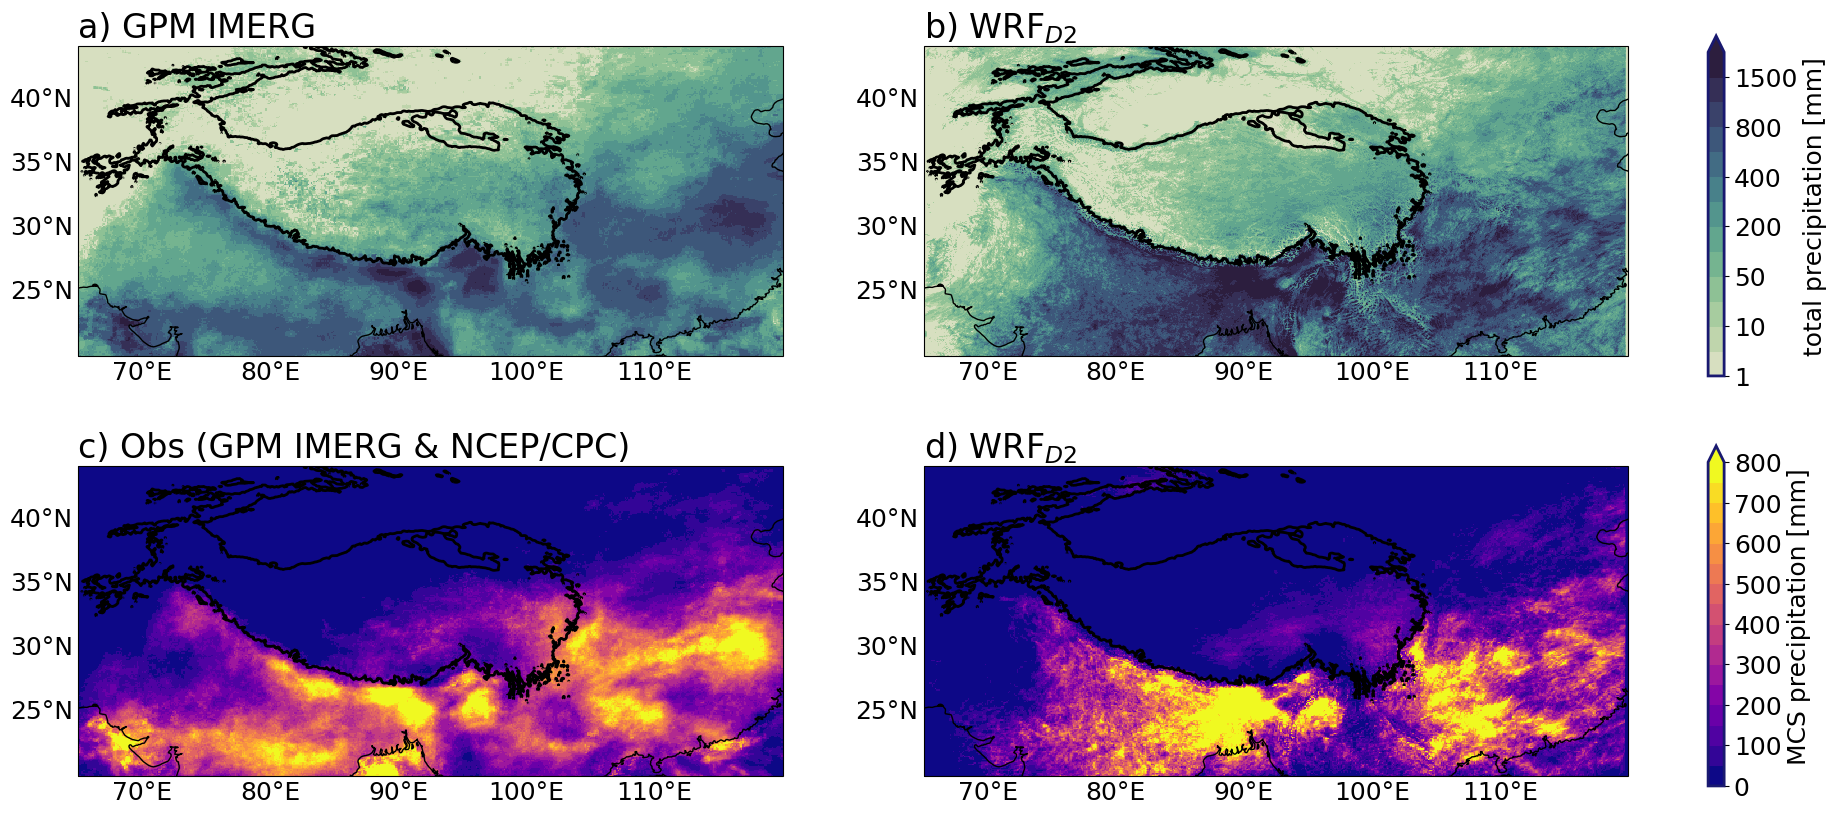

In [17]:
fig = plt.figure(figsize=(20,10))

# general settings
extent = [65,120,20,41]
fs = 18 
lw = 2.0
r= np.array([1, 5, 10, 20, 50, 100, 200, 300, 400,500, 800, 1000, 1500, 2000])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
ax = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('a) GPM IMERG', fontsize = 24, loc = 'left')
m= ax.pcolormesh(gpm.lon.T, gpm.lat.T, gpm_precip.T ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 

ax = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('b) WRF$_{D2}$', fontsize = 24, loc = 'left')
m= ax.pcolormesh(ds.lon, ds.lat,wrf_precip ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 

# colorbar 
cb_ax2 = fig.add_axes([0.94, 0.53,0.008, 0.34])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'total precipitation [mm]', size = fs)


######################################################
r= np.arange(0,95,5)
r = np.arange(0,850,50)
norm2 = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

cmap = sns.color_palette("plasma", as_cmap=True)
ax = plt.subplot(2, 2, 3 , projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('c) Obs (GPM IMERG & NCEP/CPC)', fontsize = 24, loc = 'left')
m=ax.pcolormesh(gpm.lon.T, gpm.lat.T, contribution_gpm, cmap = cmap, norm=norm2)
      

ax = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('d) WRF$_{D2}$', fontsize = 24, loc = 'left')
m= ax.pcolormesh(gpm.lon, gpm.lat, contribution_wrf ,  cmap = cmap,vmin =0, norm=norm2)
plt.rcParams.update({'font.size': fs}) 

# colorbar 
cb_ax2 = fig.add_axes([0.94, 0.12,0.008, 0.34])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'MCS precipitation [mm]', size = fs)

plt.savefig('plots/water_year_maps_precip.png', bbox_inches = 'tight', facecolor = 'white', transparent = None)
plt.show()

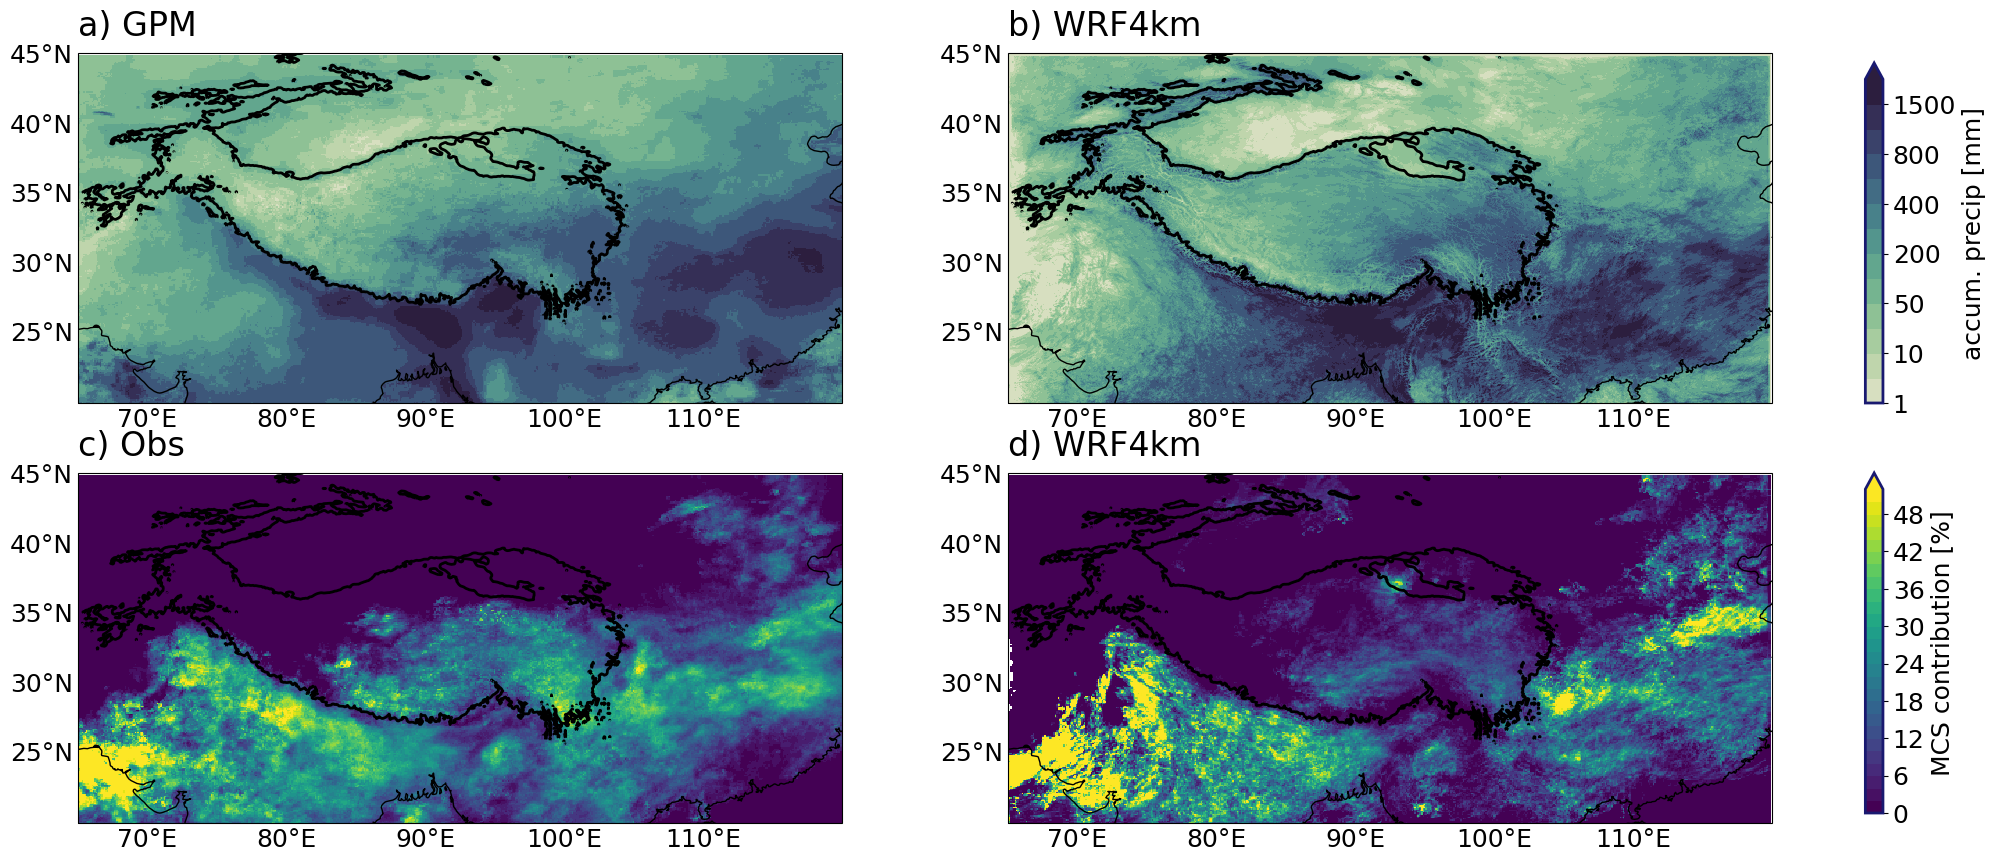

In [425]:
fig = plt.figure(figsize=(22,10))

# general settings
extent = [65,120,20,42]
fs = 18 
lw = 2.0
r= np.array([1, 5, 10, 20, 50, 100, 200,300,400,500, 800, 1000, 1500, 2000])
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

cmap = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
ax = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('a) GPM', fontsize = 24, loc = 'left')
m= ax.pcolormesh(gpm.lon.T, gpm.lat.T, gpm_precip.T ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 

ax = plt.subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('b) WRF4km', fontsize = 24, loc = 'left')
m= ax.pcolormesh(ds.lon[0], ds.lat[0],wrf_precip ,  cmap = cmap,norm = norm)
plt.rcParams.update({'font.size': fs}) 

# colorbar 
cb_ax2 = fig.add_axes([0.94, 0.53,0.008, 0.34])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'accum. precip [mm]', size = fs)


######################################################
r= np.arange(0,54,2)
norm2 = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

cmap = sns.color_palette("viridis", as_cmap=True)
ax = plt.subplot(2, 2, 3 , projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('c) Obs', fontsize = 24, loc = 'left')
m=ax.pcolormesh(gpm.lon.T, gpm.lat.T, contribution_gpm / gpm_precip.T * 100 , cmap = cmap, norm=norm2)
      

ax = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.set_extent(extent)
ax.contour(lo, la, elevations.T, levels= [3000], cmap = 'Greys_r', linewidths= [lw])
ax.coastlines(color = 'black')
gl= ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False, linewidth = 0.002)
gl.top_labels = False
gl.right_labels = False
ax.set_title('d) WRF4km', fontsize = 24, loc = 'left')
m= ax.pcolormesh(gpm.lon, gpm.lat, (contribution_wrf*3600) / wrf_regridded * 100 ,  cmap = cmap,vmin =0, norm=norm2)
plt.rcParams.update({'font.size': fs}) 

# colorbar 
cb_ax2 = fig.add_axes([0.94, 0.12,0.008, 0.34])
cbar = fig.colorbar(m, cax=cb_ax2, extend = 'max', drawedges = False)
cbar.outline.set_edgecolor('midnightblue')
cbar.outline.set_linewidth(2)
cbar.ax.tick_params(labelsize=fs)
cbar.set_label(r'MCS contribution [%]', size = fs)

plt.savefig('plots/water_year_maps_tbb.png', bbox_inches = 'tight', facecolor = 'white', transparent = None)
plt.show()

# Comparison to clouds tracks co-located with precip 

In [9]:
mcs_files

[PosixPath('/glade/scratch/kukulies/tracks/water-year/tbb/Cloud_tracking_water-year202006_spectral-nudging_WRF_precip-colocs'),
 PosixPath('/glade/scratch/kukulies/tracks/water-year/tbb/Cloud_tracking_water-year202007_spectral-nudging_WRF_precip-colocs'),
 PosixPath('/glade/scratch/kukulies/tracks/water-year/tbb/Cloud_tracking_water-year202008_spectral-nudging_WRF_precip-colocs')]

In [12]:
minlat, maxlat = 28, 33
minlon, maxlon = 102, 105

### get statistics for filtered MCSs ###
# initialize counters 
mcs_seasonal = np.zeros((12,))
mcs_sichuan = np.zeros((12,))
lifetimes_mcs = np.array(())
hours_mcs = np.array(())
hours =  4
mon = 0 
path = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
mcs_files = list(path.glob('*nudging*precip-colocs'))
mcs_files.sort()
for fname in mcs_files:
    sichuan = dict()
    newdict = dict()
    with open(fname, 'rb') as f:
        monthly = pickle.load(f)
    for key in monthly.keys():
        sichuan_flag = 0 
        # check condition on cloud and axis features by replacing entries with 1 and 0 
        pf_axis = (np.array(monthly[key]['major_axis_length']) > 100 ) * 1
        cloud_shield = (np.array(monthly[key]['rgrSize']) > 1e4 ) * 1   
        cold_core = (np.array(monthly[key]['rgrPR_Percentiles'][:, 0]) < 225 ) * 1 

        # test for continuity 
        regions = ndimage.find_objects(ndimage.label(pf_axis)[0])
        pf_regions = [np.sum(pf_axis[r]) for r in regions]
        regions = ndimage.find_objects(ndimage.label(cloud_shield)[1])
        cl_regions = [np.sum(cloud_shield[r]) for r in regions]
        regions = ndimage.find_objects(ndimage.label(cloud_shield)[1])
        cc = [np.sum(cold_core[r]) for r in regions]
            
        if np.array(cl_regions).sum() > 0 and np.array(pf_axis).sum() > 0:
            # check if more than 4 pf100km and 240K cloud shields exist:
            if np.array(cl_regions).max() > hours and np.array(cc).max() > hours and np.array(pf_regions).max() > hours:
            #np.array(monthly[key]['cloud_min']).min() < 225:
                mcs_seasonal[mon] += 1 
                newdict[key] = monthly[key].copy()
                # diurnal
                cell_hours= pd.DatetimeIndex(monthly[key]['TimeAct']).hour
                hours_mcs= np.append(hours_mcs, cell_hours) 
                # lifetime 
                lt = monthly[key]['TimeAct'].shape[0]
                lifetimes_mcs = np.append(lifetimes_mcs, lt )
                # filter out sichuan MCSs                                                              
                lats = monthly[key]['rgrMassCentLatLon'][:,1]                                                                                                
                lons = monthly[key]['rgrMassCentLatLon'][:,0]                                                                                                
                for idx, lat in enumerate(lats):
                    lon = lons[idx]
                    if lat > minlat and lat < maxlat and lon > minlon and lon < maxlon : 
                        sichuan[key]  = monthly[key].copy()
                        sichuan_flag  = 1 
                        break
                    else:
                        sichuan_flag  = 0 

                if sichuan_flag == 1:
                    mcs_sichuan[mon] +=1 
    # save MCS dict 
    with open(str(fname) + '-mcs.pickle', 'wb') as handle:
        pickle.dump(newdict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()
    with open(str(fname) + '_sichuan.pickle', 'wb') as h:
        pickle.dump(sichuan, h, protocol=pickle.HIGHEST_PROTOCOL)
    h.close()
    f.close()
    mon += 1 

hour_mcs_counts,bins = np.histogram(hours_mcs,bins = np.arange(25), normed = True) 
lifetime_mcs_counts,bins_lt = np.histogram(lifetimes_mcs, bins = np.arange(4,34,1), normed = True)

ValueError: unsupported pickle protocol: 5

In [4]:
mcs_seasonal

array([ 64.,  13.,  10.,  27.,  22.,  61.,  99., 153., 268., 320., 324.,
       201.])

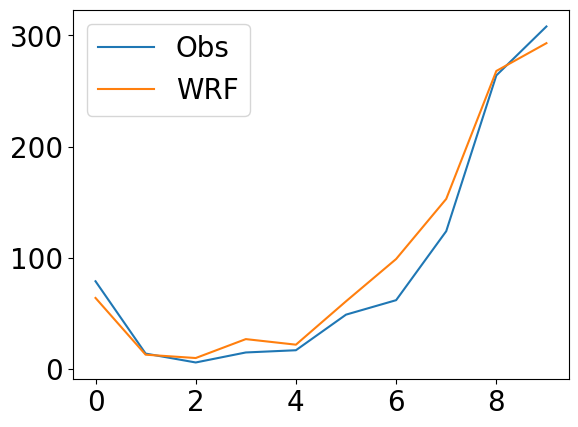

In [247]:
plt.plot(mcs_seasonal[:10], label = 'Obs')
plt.plot(mcs_seasonal_wrf[:10], label ='WRF')
plt.legend()

# Getting additional statistics to quantify performance 

In [79]:
# postprocessed WRF file 
wrf = Path('/glade/scratch/kukulies/WY2020/pr/')
wrf_jun= xr.open_dataset( wrf / 'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_2020-06_regridded.nc').pr * 3600 
wrf_jul= xr.open_dataset( wrf /  'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_2020-07_regridded.nc').pr * 3600 
wrf_aug= xr.open_dataset( wrf /  'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_2020-08_regridded.nc').pr * 3600

# postprocessed WRF nudging file 
wrf = Path('/glade/scratch/kukulies/WY2020/nudging/')
wrf_jun_n= xr.open_dataset( wrf / 'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r2i1p1_BNU-WRF421P_v1_hour_2020-06_regridded.nc').pr * 3600 
wrf_jul_n= xr.open_dataset( wrf /  'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r2i1p1_BNU-WRF421P_v1_hour_2020-07_regridded.nc').pr * 3600 
wrf_aug_n= xr.open_dataset( wrf /  'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r2i1p1_BNU-WRF421P_v1_hour_2020-08_regridded.nc').pr * 3600

# GPM file
gpm = Path('/glade/work/kukulies/obs/gpm/2019-2020/')
gpm_jun = xr.open_dataset( (gpm / '202006'/ 'gpm_202006_cat.nc_small.nc' )).precipitationCal.resample(time = '1H').mean()
gpm_jul = xr.open_dataset(( gpm / '202007'/ 'gpm_202007_cat.nc_small.nc')).precipitationCal.resample(time = '1H').mean()
gpm_aug = xr.open_dataset(( gpm / '202008'/ 'gpm_202008_cat.nc_small.nc')).precipitationCal.resample(time = '1H').mean()

gpm_precip = xr.concat([gpm_jun, gpm_jul, gpm_aug], dim = 'time')
wrf_precip = xr.concat([wrf_jun, wrf_jul, wrf_aug], dim = 'time')
wrf_precip_n = xr.concat([wrf_jun_n, wrf_jul_n, wrf_aug_n], dim = 'time')

# set missing values to NaN 
wrf_precip = wrf_precip.where(wrf_precip < 1000 )
wrf_precip_n = wrf_precip_n.where(wrf_precip_n < 1000 )

# Spatially averaged over D2 and Sichuan basin - modeled vs. observed

- total accumulated precip summer 2020 
- total accumulated precip > 5 mm/hr summer 2020
- total accumulated precip > 10 mm/hr summer 2020
- total MCS precip summer 2020 


In [95]:
minlon, maxlon = 102,105
minlat, maxlat = 28,33
# area weights for regions strectching over longer latitude range 
weights = np.cos(np.deg2rad(gpm_precip.lat))

wrf_sichuan  = wrf_precip.where(  (wrf_precip.lat > minlat ) & (wrf_precip.lat < maxlat) & (wrf_precip.lon > minlon ) & (wrf_precip.lon < maxlon), drop = True) 
wrf_total = wrf_sichuan.sum('time').mean( ['lon', 'lat' ])
wrf_total10 = wrf_sichuan.where(wrf_sichuan >=10).sum('time').weighted(weights).mean( ['lon', 'lat'] )
wrf_total5 = wrf_sichuan.where(wrf_sichuan >=5).sum('time').weighted(weights).mean( ['lon', 'lat'] )

wrf_sichuan_n  = wrf_precip_n.where(  (wrf_precip_n.lat > minlat ) & (wrf_precip_n.lat < maxlat) & (wrf_precip_n.lon > minlon ) & (wrf_precip_n.lon < maxlon), drop = True) 
wrf_total_n = wrf_sichuan_n.sum('time').mean( ['lon', 'lat' ])
wrf_total10_n = wrf_sichuan_n.where(wrf_sichuan_n >=10).sum('time').weighted(weights).mean( ['lon', 'lat'] )
wrf_total5_n = wrf_sichuan_n.where(wrf_sichuan_n >=5).sum('time').weighted(weights).mean( ['lon', 'lat'] )

gpm_sichuan  = gpm_precip.where(  (gpm_precip.lat > minlat ) & (gpm_precip.lat < maxlat) & (gpm_precip.lon > minlon ) & (gpm_precip.lon < maxlon), drop = True) 
gpm_total = gpm_sichuan.sum('time').mean( ['lon', 'lat' ])
gpm_total10 = gpm_sichuan.where(gpm_sichuan>=10).sum('time').weighted(weights).mean( ['lon', 'lat'] )
gpm_total5 = gpm_sichuan.where(gpm_sichuan>=5).sum('time').weighted(weights).mean( ['lon', 'lat'] )

In [96]:
print(gpm_total.data, wrf_total.data, wrf_total_n.data)

855.9615 802.0526488599955 845.0314975462079


In [81]:
print(gpm_total.data, wrf_total.data, wrf_total_n.data, gpm_total5.data, wrf_total5.data , wrf_total5_n.data , gpm_total10.data, wrf_total10.data, wrf_total10_n.data)

731.4259 649.3722754684565 543.7102169236805 302.72985493985243 339.4357363255874 264.2612846377508 144.66049663684015 215.89779780560445 160.11699231338088


In [90]:
### entire domain D2 

wrf_total_n = wrf_precip_n.sum('time').mean( ['lon', 'lat' ])
wrf_total5_n = wrf_precip_n.where(wrf_precip_n >=5).sum('time').weighted(weights).mean( ['lon', 'lat'])
wrf_total10_n = wrf_precip_n.where(wrf_precip_n >=10).sum('time').weighted(weights).mean( ['lon', 'lat']) 

wrf_total = wrf_precip.sum('time').mean( ['lon', 'lat' ])
wrf_total5 = wrf_precip.where(wrf_precip >=5).sum('time').weighted(weights).mean( ['lon', 'lat'])
wrf_total10 = wrf_precip.where(wrf_precip >=10).sum('time').weighted(weights).mean( ['lon', 'lat']) 

gpm_total = gpm_precip.sum('time').mean( ['lon', 'lat' ])
gpm_total5 = gpm_precip.where(gpm_precip >=5).sum('time').weighted(weights).mean( ['lon', 'lat'])
gpm_total10 = gpm_precip.where(gpm_precip >=10).sum('time').weighted(weights).mean( ['lon', 'lat'])

In [91]:
print(gpm_total.data, wrf_total.data, wrf_total_n.data, '/n', gpm_total5.data, wrf_total5.data , wrf_total5_n.data ,  gpm_total10.data, wrf_total10.data,  wrf_total10_n.data)

469.58984 464.02025075275634 385.57403281634737 /n 189.07407626216184 286.8098487090287 235.5700770453095 89.9616528416492 203.29417403871514 162.86567717605556


### MCS-associated precip 


In [89]:
minlon, maxlon = 102,105
minlat, maxlat = 28,33

In [90]:
# Data 
mcs_precip = Path('/glade/scratch/kukulies/tracks/water-year/tbb/')
gpm_mcs_precip = xr.open_dataset(mcs_precip  / 'mcs_contribution_gpm.nc')
wrf_mcs_precip = xr.open_dataset(mcs_precip  / 'mcs_contribution_wrf.nc')
wrf_mcs_precip_n = xr.open_dataset(mcs_precip  / 'mcs_contribution_wrf-nudging.nc')

# rename dims 
dims = {'dim_0': 'lat', 'dim_1':'lon'}
gpm_mcs_precip= gpm_mcs_precip.rename_dims(dims).__xarray_dataarray_variable__
wrf_mcs_precip= wrf_mcs_precip.rename_dims(dims).__xarray_dataarray_variable__
wrf_mcs_precip_n= wrf_mcs_precip_n.rename_dims(dims).__xarray_dataarray_variable__

In [91]:
# Sichuan
gpm_sichuan  = gpm_mcs_precip.where(  (gpm_precip.lat > minlat ) & (gpm_precip.lat < maxlat) & (gpm_precip.lon > minlon ) & (gpm_precip.lon < maxlon), drop = True) 
gpm_total = gpm_sichuan.where(gpm_sichuan).weighted(weights).mean( ['lon', 'lat'] ).data

wrf_sichuan_n  = wrf_mcs_precip_n.where(  (wrf_precip_n.lat > minlat ) & (wrf_precip_n.lat < maxlat) & (wrf_precip_n.lon > minlon ) & (wrf_precip_n.lon < maxlon), drop = True) 
wrf_total_n = wrf_sichuan_n.where(wrf_sichuan_n ).weighted(weights).mean( ['lon', 'lat'] ).data

wrf_sichuan  = wrf_mcs_precip.where(  (wrf_precip.lat > minlat ) & (wrf_precip.lat < maxlat) & (wrf_precip.lon > minlon ) & (wrf_precip.lon < maxlon), drop = True) 
wrf_total= wrf_sichuan.where(wrf_sichuan ).weighted(weights).mean( ['lon', 'lat'] ).data

In [92]:
print(gpm_total, wrf_total, wrf_total_n)

538.3201216513634 331.79053899543817 289.37936822872325


In [93]:
# D2
gpm_total = gpm_mcs_precip.weighted(weights).mean( ['lon', 'lat'] ).data
wrf_total_n = wrf_mcs_precip_n.weighted(weights).mean( ['lon', 'lat'] ).data
wrf_total= wrf_mcs_precip.weighted(weights).mean( ['lon', 'lat'] ).data

In [94]:
print(gpm_total, wrf_total, wrf_total_n)

205.39241582502328 166.0997134171239 120.91840969155656


# 3 strong MCS cases in WY2020

## Plot accumulated precip GPM vs. WRF for specific case

In [212]:
import datetime

year = 2020
month = 6
start= datetime.datetime(year, month, 17, 0)
end = datetime.datetime(year,month, 18 , 0 )

# postprocessed WRF file 
wrf = Path('/glade/scratch/kukulies/WY2020/pr/')
wrf_file= wrf / ( 'pr_CPTP-WY2020-4_ECMWF-ERA5_evaluation_r1i1p1_NCAR-WRF421P_v1_hour_'+ str(year)+'-' + str(month).zfill(2)+ '.nc')
wrf_data = xr.open_dataset(wrf_file)

# GPM file
gpm = Path('/glade/work/kukulies/obs/gpm/2019-2020/')
gpm_file = gpm / (str(year)  + str(month).zfill(2)) / ('gpm_' +str(year)  + str(month).zfill(2) + '_cat.nc_small.nc') 
gpm_data = xr.open_dataset(gpm_file)

# accumulated precip over period
wrf_precip = wrf_data.pr.sel(time = slice(start,end )).sum('time') * 3600
gpm_precip = gpm_data.precipitationCal.sel(time = slice(start,end )).sum('time')

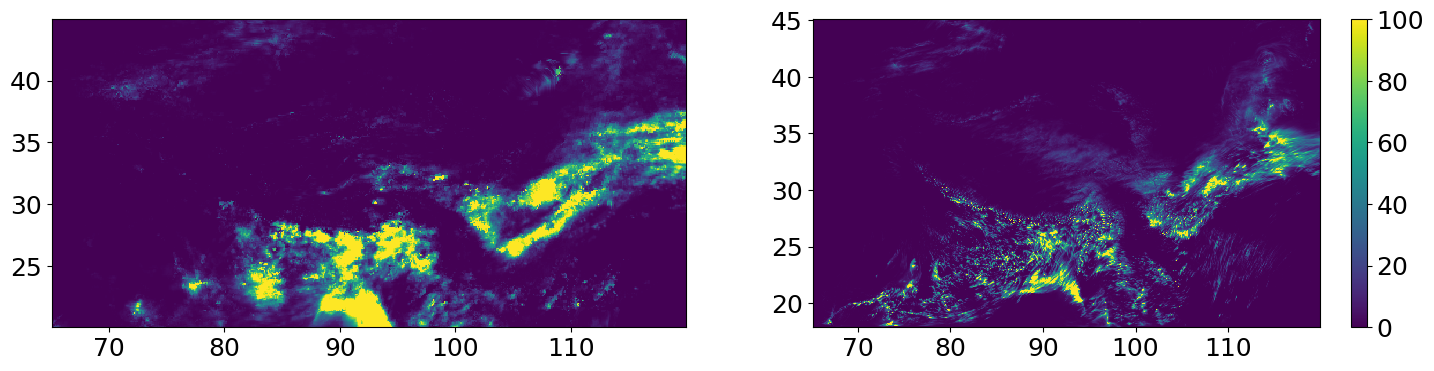

In [213]:
# plot 

plt.figure(figsize=(18,4))
ax = plt.subplot(1,2,1)
ax.pcolormesh(gpm_data.lon, gpm_data.lat, gpm_precip.T, vmin = 0, vmax = 100)

ax = plt.subplot(1,2,2)
m=ax.pcolormesh(wrf_data.lon[0], wrf_data.lat[0], wrf_precip, vmax = 100 )

plt.colorbar(m)

plt.show()

## Plot Hovmoller diagram ERA5 for specific case 

In [172]:

filename  = '/glade/work/kukulies/tracks/Cloud_tracking_water-year202006_WRF_precip-colocs_sichuan.pickle'
with open(filename, 'rb') as f:
    tracks_jun = pickle.load(f)


In [206]:
# get tracks with highest amount of precip
precip = 0 
track = 0 

for key in tracks_jun.keys():
    total_precip = np.nanmean(tracks_jun[key]['rgrPR_Mean'] ) 
    if total_precip > precip:
        precip = total_precip
        track = key 


In [205]:
del tracks_jun[key]

In [207]:
key

'3302'

In [209]:
tracks_jun[key]['TimeAct']

array(['2020-06-19T09:00:00.000000000', '2020-06-19T10:00:00.000000000',
       '2020-06-19T11:00:00.000000000', '2020-06-19T12:00:00.000000000',
       '2020-06-19T13:00:00.000000000', '2020-06-19T14:00:00.000000000',
       '2020-06-19T15:00:00.000000000', '2020-06-19T16:00:00.000000000',
       '2020-06-19T17:00:00.000000000', '2020-06-19T18:00:00.000000000',
       '2020-06-19T19:00:00.000000000', '2020-06-19T20:00:00.000000000',
       '2020-06-19T21:00:00.000000000', '2020-06-19T22:00:00.000000000',
       '2020-06-19T23:00:00.000000000'], dtype='datetime64[ns]')

In [108]:

filename  = '/glade/work/kukulies/tracks/Cloud_tracking_water-year202006_CPC_precip-colocs_sichuan.pickle'
with open(filename, 'rb') as f:
    tracks_jun = pickle.load(f)

    
filename  = '/glade/work/kukulies/tracks/Cloud_tracking_water-year202007_CPC_precip-colocs_sichuan.pickle'
with open(filename, 'rb') as f:
    tracks_jul = pickle.load(f)

    
filename  = '/glade/work/kukulies/tracks/Cloud_tracking_water-year202008_CPC_precip-colocs_sichuan.pickle'
with open(filename, 'rb') as f:
    tracks_aug = pickle.load(f)


In [109]:
for key in tracks_jun.keys():
    print(tracks_obs[key]['TimeAct'][0], tracks_obs[key]['TimeAct'].shape, np.nanmean(tracks_obs[key]['total_precip'] ), key )

2020-06-01T00:15:00.000000000 (36,) 48027.416666666664 1021
2020-06-19T05:15:00.000000000 (39,) 38002.666666666664 1697
2020-06-20T05:15:00.000000000 (27,) 13095.814814814816 1721
2020-06-21T05:15:00.000000000 (20,) 20576.25 1746
2020-06-23T04:15:00.000000000 (72,) 14712.180555555555 1788
2020-06-10T08:15:00.000000000 (39,) 30773.641025641027 2042
2020-06-11T08:15:00.000000000 (10,) 4811.8 2043
2020-06-13T07:15:00.000000000 (12,) 7818.083333333333 2074
2020-06-11T06:15:00.000000000 (14,) 10007.5 2138
2020-06-12T06:15:00.000000000 (16,) 12362.5 2160
2020-06-12T07:15:00.000000000 (13,) 4687.615384615385 2163
2020-06-15T05:15:00.000000000 (34,) 55883.470588235294 2223
2020-06-16T05:15:00.000000000 (59,) 41972.91525423729 2231
2020-06-17T06:15:00.000000000 (11,) 25404.454545454544 2241
2020-06-18T05:15:00.000000000 (21,) 24839.380952380954 2327
2020-06-22T05:15:00.000000000 (18,) 18879.166666666668 2422
2020-06-26T05:15:00.000000000 (58,) 70938.75862068965 2543
2020-06-29T05:15:00.00000000

In [111]:
for key in tracks_jul.keys():
    print(tracks_jul[key]['TimeAct'][0], tracks_jul[key]['TimeAct'].shape, np.nanmean(tracks_jul[key]['total_precip'] ), key )

2020-07-05T05:15:00.000000000 (24,) 12921.0 1340
2020-07-06T05:15:00.000000000 (27,) 21896.296296296296 1389
2020-07-10T05:15:00.000000000 (20,) 18460.2 1599
2020-07-04T07:15:00.000000000 (18,) 9359.055555555555 1904
2020-07-14T13:15:00.000000000 (21,) 9320.52380952381 2149
2020-07-17T06:15:00.000000000 (25,) 74047.8 2194
2020-07-18T08:15:00.000000000 (41,) 10058.19512195122 2257
2020-07-19T07:15:00.000000000 (30,) 13050.4 2321
2020-07-20T10:15:00.000000000 (14,) 2576.1428571428573 2389
2020-07-20T23:15:00.000000000 (37,) 6816.72972972973 2419
2020-07-22T05:15:00.000000000 (23,) 23021.304347826088 2479
2020-07-23T13:15:00.000000000 (40,) 15776.15 2559
2020-07-24T11:15:00.000000000 (81,) 59390.48148148148 2604
2020-07-15T06:15:00.000000000 (26,) 20027.576923076922 2685
2020-07-28T04:15:00.000000000 (16,) 8977.6875 3009
2020-07-30T11:15:00.000000000 (37,) 5685.216216216216 3121
2020-07-29T11:15:00.000000000 (24,) 12256.25 3258
2020-07-30T16:15:00.000000000 (16,) 8700.625 3322


In [112]:
for key in tracks_jul.keys():
    print(tracks_jul[key]['TimeAct'][0], tracks_jul[key]['TimeAct'].shape, np.nanmean(tracks_jul[key]['total_precip'] ), key)

2020-07-05T05:15:00.000000000 (24,) 12921.0 1340
2020-07-06T05:15:00.000000000 (27,) 21896.296296296296 1389
2020-07-10T05:15:00.000000000 (20,) 18460.2 1599
2020-07-04T07:15:00.000000000 (18,) 9359.055555555555 1904
2020-07-14T13:15:00.000000000 (21,) 9320.52380952381 2149
2020-07-17T06:15:00.000000000 (25,) 74047.8 2194
2020-07-18T08:15:00.000000000 (41,) 10058.19512195122 2257
2020-07-19T07:15:00.000000000 (30,) 13050.4 2321
2020-07-20T10:15:00.000000000 (14,) 2576.1428571428573 2389
2020-07-20T23:15:00.000000000 (37,) 6816.72972972973 2419
2020-07-22T05:15:00.000000000 (23,) 23021.304347826088 2479
2020-07-23T13:15:00.000000000 (40,) 15776.15 2559
2020-07-24T11:15:00.000000000 (81,) 59390.48148148148 2604
2020-07-15T06:15:00.000000000 (26,) 20027.576923076922 2685
2020-07-28T04:15:00.000000000 (16,) 8977.6875 3009
2020-07-30T11:15:00.000000000 (37,) 5685.216216216216 3121
2020-07-29T11:15:00.000000000 (24,) 12256.25 3258
2020-07-30T16:15:00.000000000 (16,) 8700.625 3322


In [62]:
track1 = tracks_obs[track]
del tracks_obs[key]
print(key)

2699


In [64]:
track2 = tracks_obs[track]
del tracks_obs[key]
print(key)

2672


In [66]:
track3 = tracks_obs[track]
del tracks_obs[key]
print(key)

2584


In [67]:
track1

{'rgrMassCent': array([[134.32063683, 300.71611632],
        [131.71237565, 308.61409225],
        [133.47141292, 323.1453857 ],
        [132.17255334, 328.62334451],
        [127.92612224, 326.31397671],
        [127.93851945, 334.74565726],
        [129.960699  , 348.85201209],
        [130.38870006, 357.10252091],
        [125.77244493, 363.22641874],
        [122.69300027, 367.45676217],
        [122.88635141, 371.36282088],
        [123.52241319, 373.5095896 ],
        [128.72780368, 376.06611275],
        [134.50087354, 379.90158023]]),
 'rgrObjSpeed': array([130.79449937, 230.17548036,  88.53026311,  76.01199177,
        132.58992287, 224.09276334, 129.91527467, 120.59481701,
         82.28164975,  61.49872224,  35.20894477,  91.19512257,
        108.99172986]),
 'rgrPR_Vol': array([5.03126489e+08, 1.21596886e+09, 4.47502255e+09, 6.64764826e+09,
        9.60633992e+09, 8.48846387e+09, 5.10998385e+09, 4.17364990e+09,
        4.99044778e+09, 5.28056846e+09, 6.45294494e+09, 5.90377

In [68]:
track2

{'rgrMassCent': array([[134.32063683, 300.71611632],
        [131.71237565, 308.61409225],
        [133.47141292, 323.1453857 ],
        [132.17255334, 328.62334451],
        [127.92612224, 326.31397671],
        [127.93851945, 334.74565726],
        [129.960699  , 348.85201209],
        [130.38870006, 357.10252091],
        [125.77244493, 363.22641874],
        [122.69300027, 367.45676217],
        [122.88635141, 371.36282088],
        [123.52241319, 373.5095896 ],
        [128.72780368, 376.06611275],
        [134.50087354, 379.90158023]]),
 'rgrObjSpeed': array([130.79449937, 230.17548036,  88.53026311,  76.01199177,
        132.58992287, 224.09276334, 129.91527467, 120.59481701,
         82.28164975,  61.49872224,  35.20894477,  91.19512257,
        108.99172986]),
 'rgrPR_Vol': array([5.03126489e+08, 1.21596886e+09, 4.47502255e+09, 6.64764826e+09,
        9.60633992e+09, 8.48846387e+09, 5.10998385e+09, 4.17364990e+09,
        4.99044778e+09, 5.28056846e+09, 6.45294494e+09, 5.90377

In [69]:
track3

{'rgrMassCent': array([[134.32063683, 300.71611632],
        [131.71237565, 308.61409225],
        [133.47141292, 323.1453857 ],
        [132.17255334, 328.62334451],
        [127.92612224, 326.31397671],
        [127.93851945, 334.74565726],
        [129.960699  , 348.85201209],
        [130.38870006, 357.10252091],
        [125.77244493, 363.22641874],
        [122.69300027, 367.45676217],
        [122.88635141, 371.36282088],
        [123.52241319, 373.5095896 ],
        [128.72780368, 376.06611275],
        [134.50087354, 379.90158023]]),
 'rgrObjSpeed': array([130.79449937, 230.17548036,  88.53026311,  76.01199177,
        132.58992287, 224.09276334, 129.91527467, 120.59481701,
         82.28164975,  61.49872224,  35.20894477,  91.19512257,
        108.99172986]),
 'rgrPR_Vol': array([5.03126489e+08, 1.21596886e+09, 4.47502255e+09, 6.64764826e+09,
        9.60633992e+09, 8.48846387e+09, 5.10998385e+09, 4.17364990e+09,
        4.99044778e+09, 5.28056846e+09, 6.45294494e+09, 5.90377